In [992]:
from shapely.geometry import Point, Polygon, LineString
from sklearn.cluster import DBSCAN, HDBSCAN
from shapely.ops import triangulate
from shapely import concave_hull
import pandas as pd
import momepy as mm
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [975]:
# create a simple polygon
p1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p2 = Polygon([(1, 0), (2, 0), (2, 1), (1, 1)])
p3 = Polygon([(0, 1), (1, 1), (1, 2), (0, 2)])
p4 = Polygon([(1, 1), (2, 1), (2, 2), (1, 2)])
p5 = Polygon([(0, 2), (1, 2), (1, 3), (0, 3)])
p6 = Polygon([(1, 2), (2, 2), (2, 3), (1, 3)])
p7 = Polygon([(0, 3), (1, 3), (1, 4), (0, 4)])
p8 = Polygon([(1, 3), (2, 3), (2, 4), (1, 4)])

p9 = Polygon([(3, 0), (4, 0), (4, 1), (3, 1)])
p10 = Polygon([(3, 1), (4, 1), (4, 2), (3, 2)])
p11 = Polygon([(3, 2), (4, 2), (4, 3), (3, 3)])
p12 = Polygon([(3, 3), (4, 3), (4, 4), (3, 4)])
p13 = Polygon([(4, 0), (5, 0), (5, 1), (4, 1)])
p14 = Polygon([(4, 1), (5, 1), (5, 2), (4, 2)])
p15 = Polygon([(4, 2), (5, 2), (5, 3), (4, 3)])
p16 = Polygon([(4, 3), (5, 3), (5, 4), (4, 4)])


# split polygons with a linestring in the middle
line = LineString([(2.5, 0), (2.5, 4)])







In [976]:
# visualize all polygons
# create a list from A to J
attribs = {'owner': ['D', 'A', 'D', 'D', 'F', 'E', 'E', 'E', 'A', 'D', 'D', 'C', 'B', 'B', 'C', 'F']}
g = gpd.GeoDataFrame(attribs, geometry=[p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16])
l = gpd.GeoDataFrame(geometry=[line])



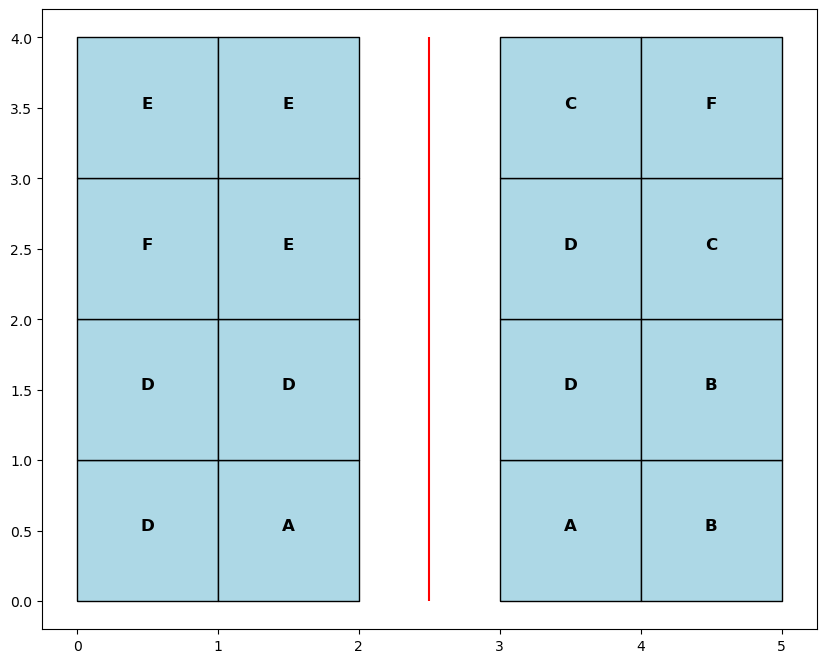

In [977]:
# visualize all polygons with their owner values
fig, ax = plt.subplots(figsize=(10, 10))
g.plot(ax=ax, edgecolor='black', facecolor='lightblue')
l.plot(ax=ax, color='red')

# Annotating each polygon with the 'owner' value at its centroid
for idx, row in g.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['owner'], horizontalalignment='center', fontsize=12, weight='bold')
plt.show()

In [978]:
g['point'] = g.centroid

In [979]:
unique_owners = g['owner'].unique()
print(unique_owners)

['D' 'A' 'F' 'E' 'C' 'B']


In [980]:
clustered_parcel_data = gpd.GeoDataFrame()
single_parcel_data = gpd.GeoDataFrame()
for owner in unique_owners:
    print(f'OWNER: {owner}')
    owner_parcels = g[g['owner'] == owner]
    owner_coords = [x.coords[0] for x in owner_parcels['point'].to_list()]
    dbscan = DBSCAN(eps=3, min_samples=2)
    clusters = dbscan.fit_predict(owner_coords)
    owner_parcels['cluster'] = clusters 
    counts = owner_parcels['cluster'].value_counts()
    print(f'Cluster Counts: {counts}')
    single_parcel_clusters = counts[counts == 1].index
    
    single_parcel_filter = owner_parcels[owner_parcels['cluster'].isin(single_parcel_clusters)]
    single_parcel_data = pd.concat([single_parcel_data, single_parcel_filter], ignore_index=True)
    
    cluster_filter = owner_parcels[(~owner_parcels['cluster'].isin(single_parcel_clusters))&(owner_parcels['cluster'] != -1)]
    clustered_parcel_data = pd.concat([clustered_parcel_data, cluster_filter], ignore_index=True)
    print('______________________________________________________________________________________')
    

    

OWNER: D
Cluster Counts: cluster
0    5
Name: count, dtype: int64
______________________________________________________________________________________
OWNER: A
Cluster Counts: cluster
0    2
Name: count, dtype: int64
______________________________________________________________________________________
OWNER: F
Cluster Counts: cluster
-1    2
Name: count, dtype: int64
______________________________________________________________________________________
OWNER: E
Cluster Counts: cluster
0    3
Name: count, dtype: int64
______________________________________________________________________________________
OWNER: C
Cluster Counts: cluster
0    2
Name: count, dtype: int64
______________________________________________________________________________________
OWNER: B
Cluster Counts: cluster
0    2
Name: count, dtype: int64
______________________________________________________________________________________


In [981]:
# create cluster ID
clustered_parcel_data['cluster_ID'] = clustered_parcel_data['owner'] + clustered_parcel_data['cluster'].astype(str)
single_parcel_data['cluster_ID'] = single_parcel_data['owner'] + single_parcel_data['cluster'].astype(str)

In [982]:
clustered_parcel_data

,owner,geometry,point,cluster,cluster_ID
0,D,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",POINT (0.50000 0.50000),0,D0
1,D,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",POINT (0.50000 1.50000),0,D0
2,D,"POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2....",POINT (1.50000 1.50000),0,D0
3,D,"POLYGON ((3.00000 1.00000, 4.00000 1.00000, 4....",POINT (3.50000 1.50000),0,D0
4,D,"POLYGON ((3.00000 2.00000, 4.00000 2.00000, 4....",POINT (3.50000 2.50000),0,D0
5,A,"POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....",POINT (1.50000 0.50000),0,A0
6,A,"POLYGON ((3.00000 0.00000, 4.00000 0.00000, 4....",POINT (3.50000 0.50000),0,A0
7,E,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....",POINT (1.50000 2.50000),0,E0
8,E,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....",POINT (0.50000 3.50000),0,E0
9,E,"POLYGON ((1.00000 3.00000, 2.00000 3.00000, 2....",POINT (1.50000 3.50000),0,E0


In [983]:
single_parcel_data

,owner,geometry,point,cluster,cluster_ID


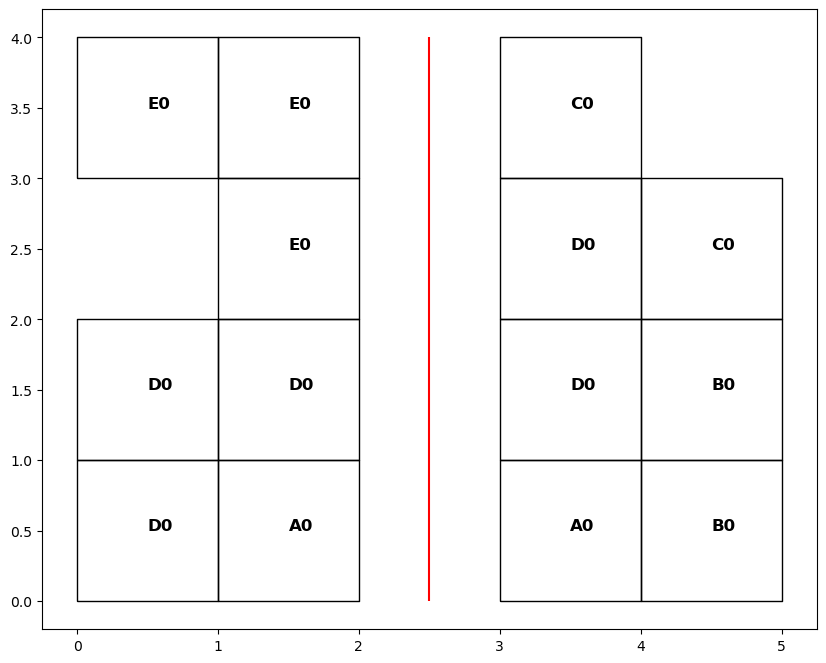

In [984]:
parcel_dissolve = clustered_parcel_data.dissolve(by='cluster_ID').reset_index()
# visualize
fig, ax = plt.subplots(figsize=(10, 10))
clustered_parcel_data.plot(ax=ax, edgecolor='black', facecolor='none')
l.plot(ax=ax, color='red')

# Annotating each polygon with the 'owner' value on left side of the polygon
for idx, row in clustered_parcel_data.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['cluster_ID'], horizontalalignment='left', fontsize=12, weight='bold')

In [985]:
super_parcels = parcel_dissolve.copy()
super_parcels

,cluster_ID,geometry,owner,point,cluster
0,A0,"MULTIPOLYGON (((1.00000 1.00000, 2.00000 1.000...",A,POINT (1.50000 0.50000),0
1,B0,"POLYGON ((5.00000 0.00000, 4.00000 0.00000, 4....",B,POINT (4.50000 0.50000),0
2,C0,"MULTIPOLYGON (((5.00000 3.00000, 5.00000 2.000...",C,POINT (3.50000 3.50000),0
3,D0,"MULTIPOLYGON (((0.00000 0.00000, 0.00000 1.000...",D,POINT (0.50000 0.50000),0
4,E0,"POLYGON ((2.00000 2.00000, 1.00000 2.00000, 1....",E,POINT (1.50000 2.50000),0


In [995]:
super_parcels['geometry'] = super_parcels['geometry'].apply(lambda x: concave_hull(x))

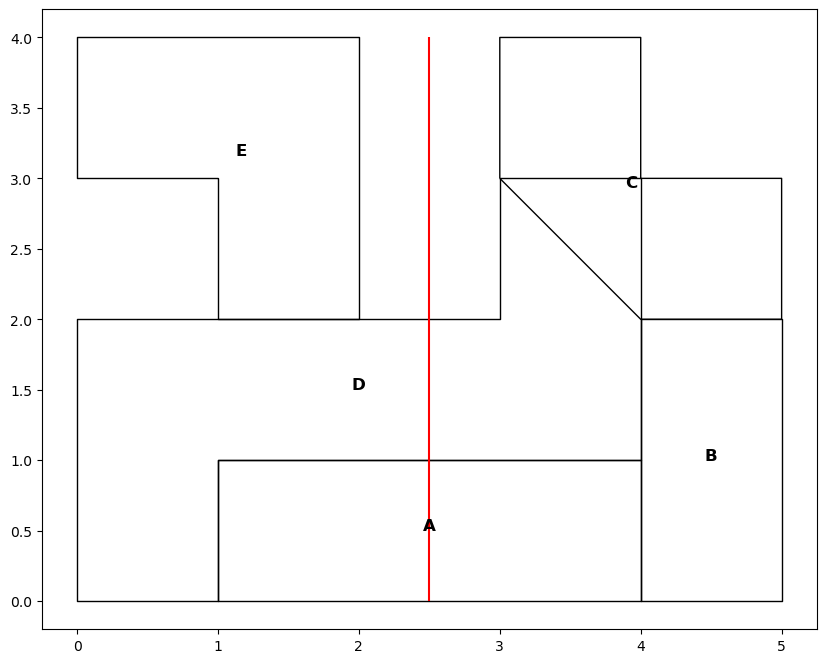

In [996]:
# visualize
fig, ax = plt.subplots(figsize=(10, 10))
super_parcels.plot(ax=ax, edgecolor='black', facecolor='none')
l.plot(ax=ax, color='red')
# add the single parcel data
if not single_parcel_data.empty:
    single_parcel_data.plot(ax=ax, edgecolor='black', facecolor='none')


# Annotating each polygon with the 'owner' value on left side of the polygon
for idx, row in super_parcels.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['owner'], horizontalalignment='center', fontsize=12, weight='bold')

# annotate single parcel data
for idx, row in single_parcel_data.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['owner'], horizontalalignment='center', fontsize=12, weight='bold')

In [874]:
super_parcels

,cluster_ID,geometry,owner,point,cluster
0,A0,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 4....",A,POINT (1.50000 0.50000),0
1,B0,"POLYGON ((4.00000 0.00000, 4.00000 2.00000, 5....",B,POINT (4.50000 0.50000),0
2,C0,"POLYGON ((4.00000 2.00000, 3.00000 3.00000, 3....",C,POINT (3.50000 3.50000),0
3,D0,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 3....",D,POINT (0.50000 0.50000),0
4,E0,"POLYGON ((1.00000 2.00000, 0.00000 3.00000, 0....",E,POINT (1.50000 2.50000),0


In [997]:

for idx, parcel in super_parcels.iterrows():
    parcel_geom = gpd.GeoDataFrame(geometry=[parcel.geometry])
    parcel_id = parcel['cluster_ID']    
    other_sp = super_parcels.loc[super_parcels['cluster_ID'] != parcel_id]
    other_union = gpd.GeoDataFrame(geometry=[other_sp.unary_union])
    parcel_clip = (gpd.overlay(parcel_geom, other_union, how='difference')
                    .explode(ignore_index=True)
                    .reset_index(drop=True))
    parcel_clip['cluster_ID'] = parcel_id
    parcel_clip['owner'] = parcel['owner']
    # drop correspnding row in super_parcels
    super_parcels = super_parcels[super_parcels['cluster_ID'] != parcel_id]
    # add parcel clip to super_parcels
    super_parcels = pd.concat([super_parcels, parcel_clip], ignore_index=True)
    

In [998]:
super_parcels = super_parcels[['owner', 'cluster_ID', 'geometry']]
super_parcels

,owner,cluster_ID,geometry
0,A,A0,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2...."
1,B,B0,"POLYGON ((4.00000 2.00000, 5.00000 2.00000, 5...."
2,C,C0,"POLYGON ((3.00000 4.00000, 4.00000 4.00000, 4...."
3,C,C0,"POLYGON ((4.00000 3.00000, 5.00000 3.00000, 5...."
4,D,D0,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 2...."
5,E,E0,"POLYGON ((0.00000 3.00000, 0.00000 4.00000, 1...."


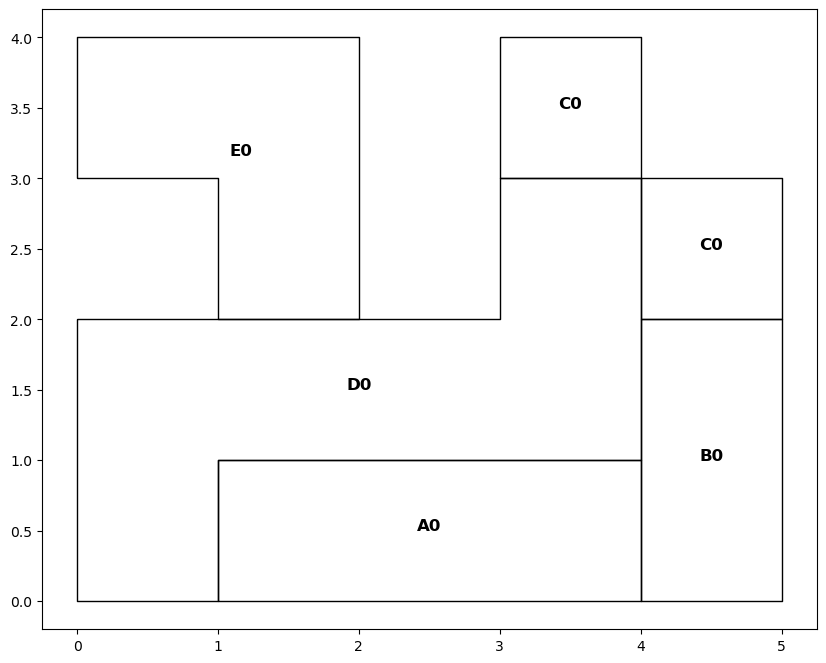

In [999]:
# visualize
fig, ax = plt.subplots(figsize=(10, 10))
super_parcels.plot(ax=ax, edgecolor='black', facecolor='none')

# Annotating each polygon with the 'owner' value on left side of the polygon
for idx, row in super_parcels.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['cluster_ID'], horizontalalignment='center', fontsize=12, weight='bold')

In [1000]:
super_parcels

,owner,cluster_ID,geometry
0,A,A0,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2...."
1,B,B0,"POLYGON ((4.00000 2.00000, 5.00000 2.00000, 5...."
2,C,C0,"POLYGON ((3.00000 4.00000, 4.00000 4.00000, 4...."
3,C,C0,"POLYGON ((4.00000 3.00000, 5.00000 3.00000, 5...."
4,D,D0,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 2...."
5,E,E0,"POLYGON ((0.00000 3.00000, 0.00000 4.00000, 1...."


In [1001]:
clipped_sp = super_parcels.copy()

In [1002]:
single_union = gpd.GeoDataFrame(geometry=[single_parcel_data.unary_union])

In [1003]:
clipped_sp_final = gpd.overlay(clipped_sp, single_union, how='difference')
clipped_sp_final

,owner,cluster_ID,geometry
0,A,A0,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2...."
1,B,B0,"POLYGON ((4.00000 2.00000, 5.00000 2.00000, 5...."
2,C,C0,"POLYGON ((3.00000 4.00000, 4.00000 4.00000, 4...."
3,C,C0,"POLYGON ((4.00000 3.00000, 5.00000 3.00000, 5...."
4,D,D0,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 2...."
5,E,E0,"POLYGON ((0.00000 3.00000, 0.00000 4.00000, 1...."


In [1004]:
clipped_sp_final = clipped_sp_final.explode(ignore_index=True)
clipped_sp_final['superparcel_ID'] = clipped_sp_final['cluster_ID'] + "_" + clipped_sp_final.groupby('cluster_ID').cumcount().astype(str) 

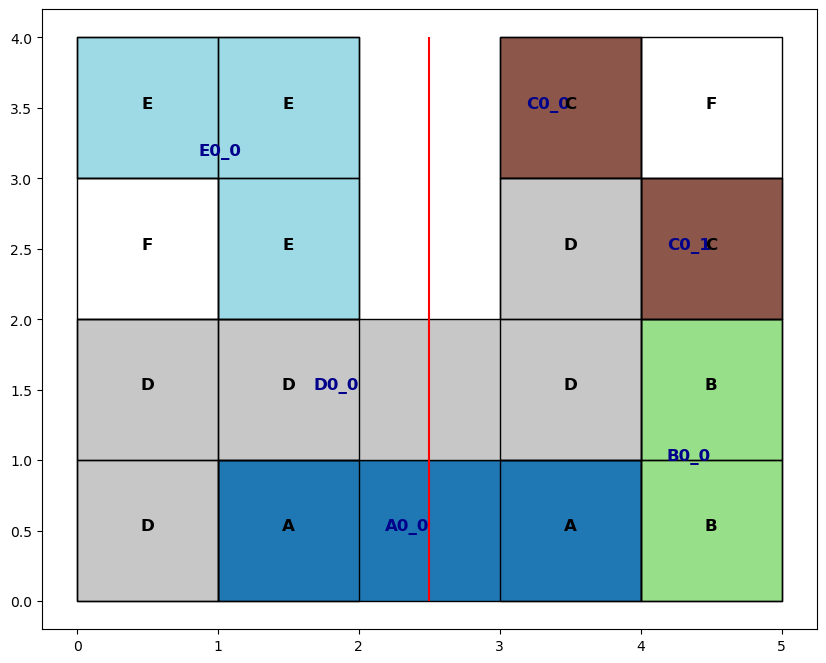

In [1009]:

# visualize
fig, ax = plt.subplots(figsize=(10, 10))
# visualize based on cluster_ID
clipped_sp_final.plot(ax=ax, edgecolor='black', facecolor='lightblue', column='cluster_ID', cmap='tab20')
unique_clusters = clipped_sp_final['superparcel_ID'].unique()
cmap = plt.cm.get_cmap('tab20', len(unique_clusters))
cluster_to_color = {cluster: cmap(i) for i, cluster in enumerate(unique_clusters)}

l.plot(ax=ax, color='red')
# add the single parcel data with no color
if not single_parcel_data.empty:
    single_parcel_data.plot(ax=ax, edgecolor='black', facecolor='none')
g.plot(ax=ax, edgecolor='black', facecolor='none')  

# Annotating each polygon with the 'owner' value on left side of the polygon
for idx, row in clipped_sp_final.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['superparcel_ID'], horizontalalignment='right', fontsize=12, weight='bold', color='darkblue')

# annotate single parcel data
for idx, row in g.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['owner'], horizontalalignment='center', fontsize=12, weight='bold')